In [2]:
from keras.applications import VGG16

In [35]:
conv_base = VGG16(weights='imagenet',
               include_top=False,
               input_shape=(150, 150, 3))

In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [11]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [12]:
base_dir = '/home/ubuntu/deep-chollet/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [17]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [20]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 804us/step - loss: 0.6118 - acc: 0.6650 - val_loss: 0.4377 - val_acc: 0.8260
Epoch 2/30
2000/2000 [==============================] - 1s 309us/step - loss: 0.4414 - acc: 0.7950 - val_loss: 0.3579 - val_acc: 0.8650
Epoch 3/30
2000/2000 [==============================] - 1s 310us/step - loss: 0.3588 - acc: 0.8440 - val_loss: 0.3177 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 1s 309us/step - loss: 0.3164 - acc: 0.8620 - val_loss: 0.2937 - val_acc: 0.8890
Epoch 5/30
2000/2000 [==============================] - 1s 310us/step - loss: 0.2956 - acc: 0.8820 - val_loss: 0.2837 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 1s 309us/step - loss: 0.2614 - acc: 0.8940 - val_loss: 0.2712 - val_acc: 0.8970
Epoch 7/30
2000/2000 [==============================] - 1s 309us/step - loss: 0.2527 - acc: 0.8965 - val_loss: 0.2629 - val_acc: 0.8990


<Figure size 432x288 with 0 Axes>

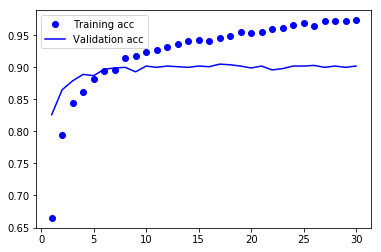

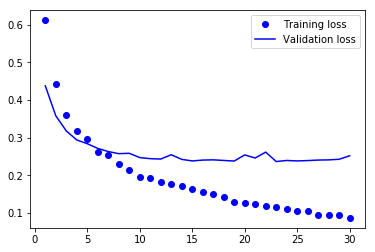

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.figure()

In [42]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
print(len(model.trainable_weights))
conv_base.trainable = False
print(len(model.trainable_weights))

4
4


In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 27s 269ms/step - loss: 0.5959 - acc: 0.6985 - val_loss: 0.4567 - val_acc: 0.8190
Epoch 2/30
100/100 [==============================] - 24s 244ms/step - loss: 0.4930 - acc: 0.7780 - val_loss: 0.3763 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 25s 246ms/step - loss: 0.4405 - acc: 0.8020 - val_loss: 0.3331 - val_acc: 0.8740
Epoch 4/30
100/100 [==============================] - 25s 246ms/step - loss: 0.3968 - acc: 0.8255 - val_loss: 0.3107 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 25s 246ms/step - loss: 0.3846 - acc: 0.8290 - val_loss: 0.2943 - val_acc: 0.8890
Epoch 6/30
100/100 [==============================] - 25s 254ms/step - loss: 0.3619 - acc: 0.8370 - val_loss: 0.2826 - val_acc: 0.8890
Epoch 7/30
100/100 [==============================] - 25s 245ms/step - loss: 0.3582 - acc: 0.8455 - val_lo

<Figure size 432x288 with 0 Axes>

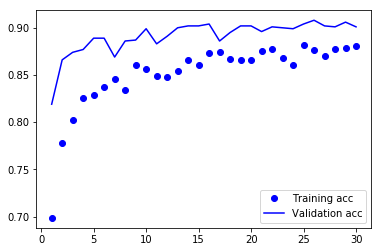

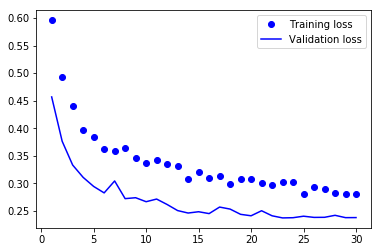

<Figure size 432x288 with 0 Axes>

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.figure()

In [46]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [48]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True 
    else:
        layer.trainable = False

In [49]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 27s 268ms/step - loss: 0.2972 - acc: 0.8665 - val_loss: 0.2334 - val_acc: 0.9050
Epoch 2/100
100/100 [==============================] - 25s 248ms/step - loss: 0.2540 - acc: 0.8865 - val_loss: 0.2061 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 0.2533 - acc: 0.8965 - val_loss: 0.2001 - val_acc: 0.9240
Epoch 4/100
100/100 [==============================] - 25s 247ms/step - loss: 0.2247 - acc: 0.9055 - val_loss: 0.1947 - val_acc: 0.9240
Epoch 5/100
100/100 [==============================] - 25s 247ms/step - loss: 0.2022 - acc: 0.9150 - val_loss: 0.2213 - val_acc: 0.9230
Epoch 6/100
100/100 [==============================] - 25s 249ms/step - loss: 0.2032 - acc: 0.9115 - val_loss: 0.2554 - val_acc: 0.9100
Epoch 7/100
100/100 [==============================] - 25s 246ms/step - loss: 0.1828 - acc: 0.9265 - val_loss: 0.1865 - val_acc: 0.9240
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 26s 265ms/step - loss: 0.0301 - acc: 0.9905 - val_loss: 0.3584 - val_acc: 0.9190
Epoch 62/100
100/100 [==============================] - 26s 258ms/step - loss: 0.0409 - acc: 0.9850 - val_loss: 0.2672 - val_acc: 0.9280
Epoch 63/100
100/100 [==============================] - 26s 256ms/step - loss: 0.0289 - acc: 0.9890 - val_loss: 0.2466 - val_acc: 0.9360
Epoch 64/100
100/100 [==============================] - 25s 254ms/step - loss: 0.0267 - acc: 0.9895 - val_loss: 0.2775 - val_acc: 0.9300
Epoch 65/100
100/100 [==============================] - 25s 246ms/step - loss: 0.0298 - acc: 0.9880 - val_loss: 0.2311 - val_acc: 0.9410
Epoch 66/100
100/100 [==============================] - 25s 251ms/step - loss: 0.0294 - acc: 0.9900 - val_loss: 0.2867 - val_acc: 0.9370
Epoch 67/100
100/100 [==============================] - 26s 256ms/step - loss: 0.0236 - acc: 0.9910 - val_loss: 0.2306 - val_acc: 0.9410
Epoch 68/100
100/100 [===================

<Figure size 432x288 with 0 Axes>

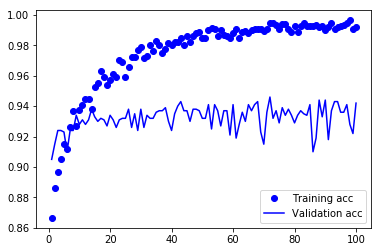

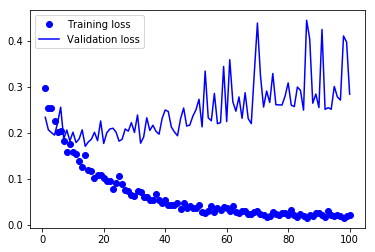

<Figure size 432x288 with 0 Axes>

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend()
plt.figure()

In [51]:
def smooth_curve(points, factor=.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

<Figure size 432x288 with 0 Axes>

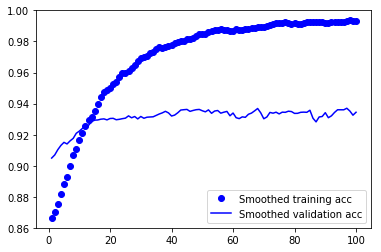

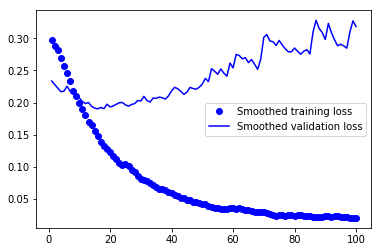

<Figure size 432x288 with 0 Axes>

In [53]:
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.legend()
plt.figure()

In [54]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9429999899864197
